Alexnet - pretrain = true

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


def load_alexnet(num_classes):
    model = models.alexnet(pretrained=True)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(236, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_alexnet(num_classes=10)

    print(f'Training AlexNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy[-1]:.2f}%')
   
accs = np.array(accuracy)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 72.1MB/s]


Training AlexNet on CIFAR-10

Test set: Average loss: 0.2281, Accuracy: 374/400 (93.50%)

accuracy on CIFAR-10: 93.50%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.5820, Accuracy: 292/400 (73.00%)

accuracy on CIFAR-10: 73.00%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.4200, Accuracy: 341/400 (85.25%)

accuracy on CIFAR-10: 85.25%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.2422, Accuracy: 360/400 (90.00%)

accuracy on CIFAR-10: 90.00%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.4597, Accuracy: 329/400 (82.25%)

accuracy on CIFAR-10: 82.25%
Iteration:  5
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.4593, Accuracy: 320

Alexnet - pretrain = false

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState

def load_alexnet(num_classes, pretrain=False):
    model = models.alexnet(pretrained=pretrain)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(256, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
# cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy1 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_alexnet(num_classes=10, pretrain=False)

    print(f'Training AlexNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy1.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy1[-1]:.2f}%')
   
accs = np.array(accuracy1)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.6988, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.6976, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.7143, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.6997, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training AlexNet on CIFAR-10

Test set: Average loss: 0.7124, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  5
Num Samples For Trainin

In [10]:
import matplotlib.pyplot as plt


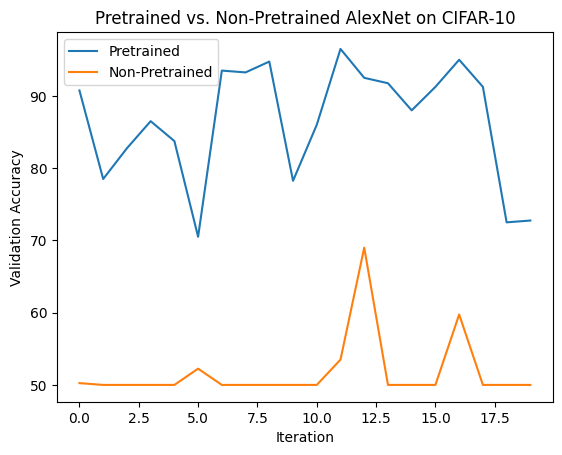

In [ ]:
plt.plot(range(seed+1), accuracy, label="Pretrained")
plt.plot(range(seed+1), accuracy1, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained vs. Non-Pretrained AlexNet on CIFAR-10")
plt.legend()
plt.show()


#Resnet with pretrain = true

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


def load_resnet(num_classes):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy2 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_resnet(num_classes=10)

    print(f'Training ResNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy2.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy2[-1]:.2f}%')
   
accs2 = np.array(accuracy2)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs2.mean(),accs2.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2905, Accuracy: 383/400 (95.75%)

accuracy on CIFAR-10: 95.75%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.5317, Accuracy: 363/400 (90.75%)

accuracy on CIFAR-10: 90.75%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.6467, Accuracy: 353/400 (88.25%)

accuracy on CIFAR-10: 88.25%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.1745, Accuracy: 394/400 (98.50%)

accuracy on CIFAR-10: 98.50%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.5444, Accuracy: 350/400 (87.50%)

accuracy on CIFAR-10: 87.50%
Iteration:  5
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.7028, Accuracy: 356/400 (89.00%)

accuracy on CIFAR-1

#resnet pretrain = false

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


def load_resnet(num_classes):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(236, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy3 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_resnet(num_classes=10)

    print(f'Training ResNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy3.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy3[-1]:.2f}%')
   
accs3 = np.array(accuracy3)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs.mean(),accs.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 1.6490, Accuracy: 250/400 (62.50%)

accuracy on CIFAR-10: 62.50%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 2.7450, Accuracy: 195/400 (48.75%)

accuracy on CIFAR-10: 48.75%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 4.0681, Accuracy: 199/400 (49.75%)

accuracy on CIFAR-10: 49.75%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 4.2352, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 3.9901, Accuracy: 207/400 (51.75%)

accuracy on CIFAR-10: 51.75%
Iter

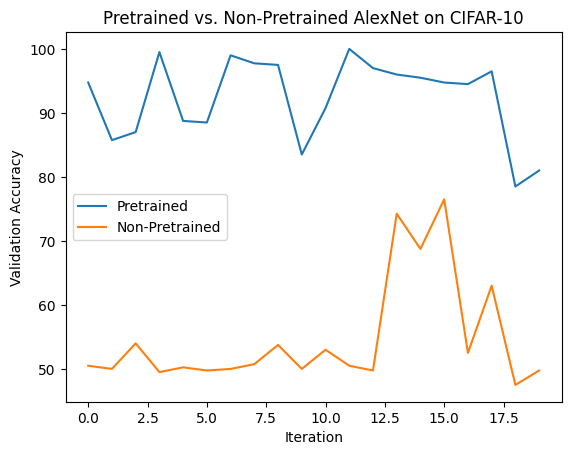

In [ ]:
plt.plot(range(seed+1), accuracy2, label="Pretrained")
plt.plot(range(seed+1), accuracy3, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained vs. Non-Pretrained AlexNet on CIFAR-10")
plt.legend()
plt.show()


#mobilenet - pretrain = true

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


def load_mobilenet(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(236, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy4 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_mobilenet(num_classes=10)

    print(f'Training MobileNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy4.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy4[-1]:.2f}%')
   
accs4 = np.array(accuracy4)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs4.mean(),accs4.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Test set: Average loss: 0.5096, Accuracy: 359/400 (89.75%)

accuracy on CIFAR-10: 89.75%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 1.1005, Accuracy: 257/400 (64.25%)

accuracy on CIFAR-10: 64.25%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 0.7269, Accuracy: 330/400 (82.50%)

accuracy on CIFAR-10: 82.50%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 0.4106, Accuracy: 366/400 (91.50%)

accuracy on CIFAR-10: 91.50%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 0.5669, Accuracy: 350/400 (87.50%)

accuracy on CIFAR-10: 87.50%
Iteration:  5
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 0.8241, Accuracy: 314/400 (78.50%)

accu

#mobilenet - pretrain = False

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


def load_mobilenet(num_classes):
    model = models.mobilenet_v2(pretrained=False)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy5 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=10, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=10, shuffle=False)

    model = load_mobilenet(num_classes=10)

    print(f'Training MobileNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy5.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy5[-1]:.2f}%')
   
accs5 = np.array(accuracy5)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs5.mean(),accs5.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 0.6817, Accuracy: 307/400 (76.75%)

accuracy on CIFAR-10: 76.75%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 1.5462, Accuracy: 219/400 (54.75%)

accuracy on CIFAR-10: 54.75%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 1.0159, Accuracy: 280/400 (70.00%)

accuracy on CIFAR-10: 70.00%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 1.2717, Accuracy: 264/400 (66.00%)

accuracy on CIFAR-10: 66.00%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training MobileNet on CIFAR-10

Test set: Average loss: 1.8444, Accuracy: 248/400 (62.00%)

accuracy on CIFAR-

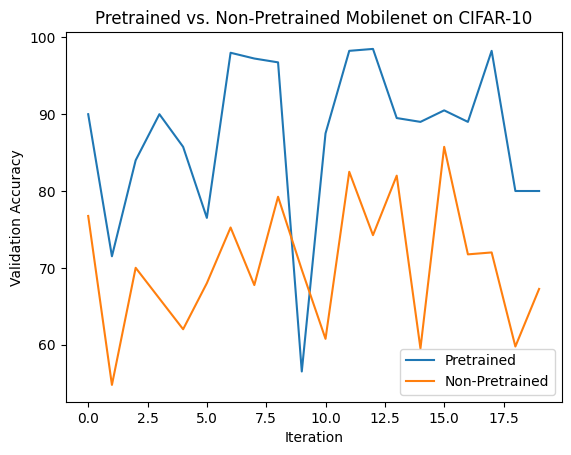

In [32]:
plt.plot(range(seed+1), accuracy4, label="Pretrained")
plt.plot(range(seed+1), accuracy5, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained vs. Non-Pretrained Mobilenet on CIFAR-10")
plt.legend()
plt.show()

#effnet - pretrain = true


In [7]:
pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


from efficientnet_pytorch import EfficientNet

def load_efficientnet(num_classes):
    model = EfficientNet.from_pretrained('efficientnet-b0')
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy6 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, shuffle=False)

    model = load_efficientnet(num_classes=10)

    print(f'Training ResNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(20):

        train(model, train_loader, criterion, optimizer, device)

    accuracy6.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy6[-1]:.2f}%')
   
accs6 = np.array(accuracy6)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs6.mean(),accs6.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 129MB/s]


Loaded pretrained weights for efficientnet-b0
Training ResNet on CIFAR-10

Test set: Average loss: 1.4254, Accuracy: 380/400 (95.00%)

accuracy on CIFAR-10: 95.00%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Loaded pretrained weights for efficientnet-b0
Training ResNet on CIFAR-10

Test set: Average loss: 1.7345, Accuracy: 301/400 (75.25%)

accuracy on CIFAR-10: 75.25%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Loaded pretrained weights for efficientnet-b0
Training ResNet on CIFAR-10

Test set: Average loss: 1.4393, Accuracy: 334/400 (83.50%)

accuracy on CIFAR-10: 83.50%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Loaded pretrained weights for efficientnet-b0
Training ResNet on CIFAR-10

Test set: Average loss: 1.3573, Accuracy: 382/400 (95.50%)

accuracy on CIFAR-10: 95.50%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Loaded pretrained weights for efficientnet-b0
Training ResNet on CIFAR-10

Test 

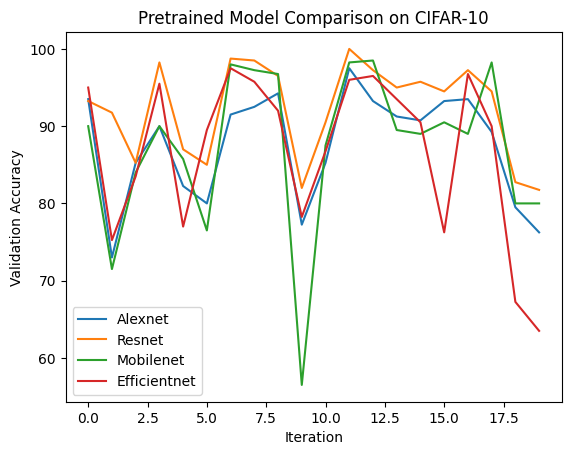

In [12]:
plt.plot(range(seed+1), accuracy, label="Alexnet")
plt.plot(range(seed+1), accuracy2, label="Resnet")
plt.plot(range(seed+1), accuracy4, label="Mobilenet")
plt.plot(range(seed+1), accuracy6, label="Efficientnet")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained Model Comparison on CIFAR-10")
plt.legend()
plt.show()


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
import torch.nn.functional as F


from efficientnet_pytorch import EfficientNet

def load_efficientnet(num_classes, pretrain=False):
    if pretrain:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    else:
        model = EfficientNet.from_name('efficientnet-b0')
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    return model


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Load CIFAR-10 dataset
transform_cifar = transforms.Compose([
    transforms.Resize(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy7 = []
seed = 20
# Train the AlexNet model on the CIFAR-10 dataset
for seed in range(seed):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])
    

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)

    print(f"Iteration: ", seed)
    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=10, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=10, shuffle=False)

    model = load_efficientnet(num_classes=10, pretrain=False)

    print(f'Training ResNet on CIFAR-10')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)

    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(100):

        train(model, train_loader, criterion, optimizer, device)
        

    accuracy7.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy7[-1]:.2f}%')
   
accs7 = np.array(accuracy7)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs7.mean(),accs7.std()))

Files already downloaded and verified
Files already downloaded and verified
Iteration:  0
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.4277, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  1
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 1.5442, Accuracy: 203/400 (50.75%)

accuracy on CIFAR-10: 50.75%
Iteration:  2
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 1.1941, Accuracy: 215/400 (53.75%)

accuracy on CIFAR-10: 53.75%
Iteration:  3
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 5.1158, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  4
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 2.4543, Accuracy: 200/400 (50.00%)

accuracy on CIFAR-10: 50.00%
Iteration:  5
Num Samples For Training 50 Num Samples For Val 400
Training ResNet on CIFAR-10

Test set: Average loss: 0.8741, Accuracy: 237/400 (59.25%)

accuracy on CIFAR-1

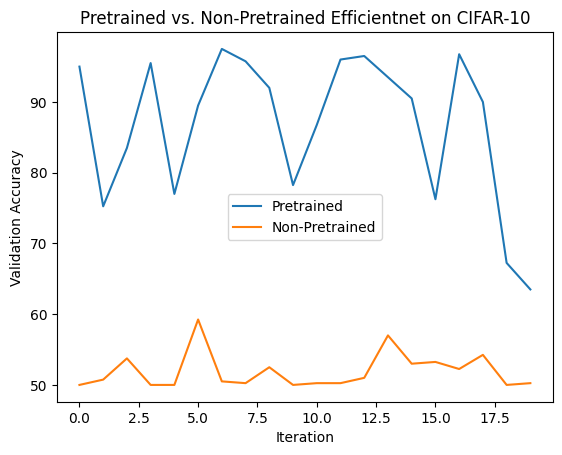

In [61]:
plt.plot(range(seed+1), accuracy6, label="Pretrained")
plt.plot(range(seed+1), accuracy7, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained vs. Non-Pretrained Efficientnet on CIFAR-10")
plt.legend()
plt.show()

#STL10 - resnet

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState

def load_resnet(num_classes):
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output)
            # print(target)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

transform_cifar_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_cifar_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_train)
cifar_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_val)

stl10_data = datasets.STL10(root='./data', split='train', download=True, transform=transform_cifar_train)
train_size = int(0.8 * len(stl10_data))
test_size = len(stl10_data) - train_size
train_data, test_data = torch.utils.data.random_split(stl10_data, [train_size, test_size])
st10_train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
st10_val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = load_resnet(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

for epoch in range(30):
  print("epoch ", epoch+1)
  train(model, st10_train_loader, criterion, optimizer, device)
  scheduler.step()

accuracy8 = test(model, st10_val_loader, device)
print(f'Accuracy on 50 CIFAR-10 samples: {accuracy8:.2f}%')

params = model.state_dict()
accuracy9 = []
for seed in range(20):
    print(f"Iteration: ", seed)
    model.load_state_dict(params)
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, 
                                            shuffle=False)


    for epoch in range(20):
        train(model, train_loader, criterion, optimizer, device)
    accuracy9.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy9[-1]:.2f}%')
   
accs13 = np.array(accuracy9)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs13.mean(),accs13.std()))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30

Test set: Average loss: 1.9750, Accuracy: 573/1000 (57.30%)

Accuracy on 50 CIFAR-10 samples: 57.30%
Iteration:  0

Test set: Average loss: 1.2300, Accuracy: 297/400 (74.25%)

accuracy on CIFAR-10: 74.25%
Iteration:  1

Test set: Average loss: 1.9897, Accuracy: 215/400 (53.75%)

accuracy on CIFAR-10: 53.75%
Iteration:  2

Test set: Average loss: 1.4905, Accuracy: 279/400 (69.75%)

accuracy on CIFAR-10: 69.75%
Iteration:  3

Test set: Average loss: 0.4529, Accuracy: 356/400 (89.00%)

accuracy on CIFAR-10: 89.00%
Iteration:  4

Test set: Average loss: 1.5591, Accuracy: 277/400 (69.25%)

accuracy on CIFAR-10: 69.25%
Iteration:  5

Test set: Average loss: 2.6630, Accuracy: 248/400 (62.00%)

accuracy on 

In [ ]:
import matplotlib.pyplot as plt


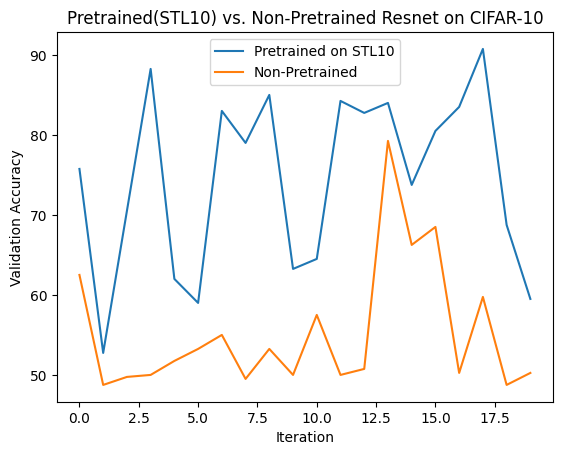

In [66]:
plt.plot(range(seed+1), accuracy9, label="Pretrained on STL10")
plt.plot(range(seed+1), accuracy3, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained(STL10) vs. Non-Pretrained Resnet on CIFAR-10")
plt.legend()
plt.show()


#STL10 - ALEXNET

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState

def load_alexnet(num_classes):
    model = models.alexnet(pretrained=False)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    return model


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output)
            # print(target)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

transform_cifar_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_cifar_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_train)
cifar_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_val)

stl10_data = datasets.STL10(root='./data', split='train', download=True, transform=transform_cifar_train)
train_size = int(0.8 * len(stl10_data))
test_size = len(stl10_data) - train_size
train_data, test_data = torch.utils.data.random_split(stl10_data, [train_size, test_size])
st10_train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
st10_val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = load_alexnet(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

for epoch in range(30):
  print("epoch ", epoch+1)
  train(model, st10_train_loader, criterion, optimizer, device)
  scheduler.step()

accuracy10 = test(model, st10_val_loader, device)
print(f'Accuracy on STL-10: {accuracy10:.2f}%')

params = model.state_dict()
accuracy11 = []
for seed in range(20):
    print(f"Iteration: ", seed)
    model.load_state_dict(params)
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, 
                                            shuffle=False)


    for epoch in range(20):
        train(model, train_loader, criterion, optimizer, device)
    accuracy11.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy11[-1]:.2f}%')
   
accs14 = np.array(accuracy11)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs14.mean(),accs14.std()))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30

Test set: Average loss: 1.3917, Accuracy: 558/1000 (55.80%)

Accuracy on STL-10: 55.80%
Iteration:  0

Test set: Average loss: 0.4615, Accuracy: 351/400 (87.75%)

accuracy on CIFAR-10: 87.75%
Iteration:  1

Test set: Average loss: 0.8677, Accuracy: 300/400 (75.00%)

accuracy on CIFAR-10: 75.00%
Iteration:  2

Test set: Average loss: 0.5225, Accuracy: 324/400 (81.00%)

accuracy on CIFAR-10: 81.00%
Iteration:  3

Test set: Average loss: 0.2758, Accuracy: 367/400 (91.75%)

accuracy on CIFAR-10: 91.75%
Iteration:  4

Test set: Average loss: 0.6563, Accuracy: 303/400 (75.75%)

accuracy on CIF

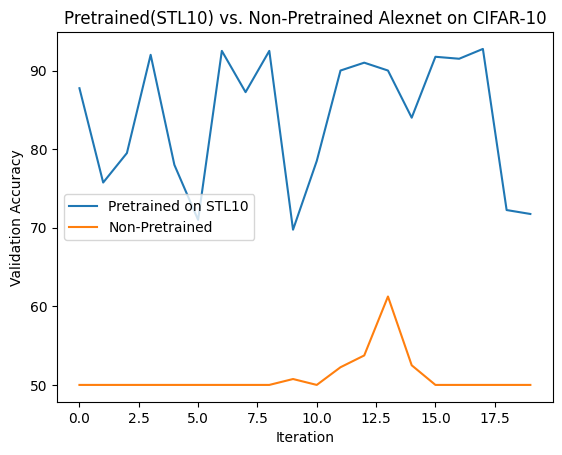

In [74]:
plt.plot(range(seed+1), accuracy11, label="Pretrained on STL10")
plt.plot(range(seed+1), accuracy1, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained(STL10) vs. Non-Pretrained Alexnet on CIFAR-10")
plt.legend()
plt.show()


#STL10 - MOBILENET


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState

def load_mobilenet(num_classes):
    model = models.mobilenet_v2(pretrained=False)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output)
            # print(target)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

transform_cifar_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_cifar_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_train)
cifar_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_val)

stl10_data = datasets.STL10(root='./data', split='train', download=True, transform=transform_cifar_train)
train_size = int(0.8 * len(stl10_data))
test_size = len(stl10_data) - train_size
train_data, test_data = torch.utils.data.random_split(stl10_data, [train_size, test_size])
st10_train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
st10_val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = load_mobilenet(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

for epoch in range(30):
  print("epoch ", epoch+1)
  train(model, st10_train_loader, criterion, optimizer, device)
  scheduler.step()

accuracy12 = test(model, st10_val_loader, device)
print(f'Accuracy on 50 CIFAR-10 samples: {accuracy12:.2f}%')

params = model.state_dict()
accuracy13 = []
for seed in range(20):
    print(f"Iteration: ", seed)
    model.load_state_dict(params)
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, 
                                            shuffle=False)


    for epoch in range(20):
        train(model, train_loader, criterion, optimizer, device)
    accuracy13.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy13[-1]:.2f}%')
   
accs15 = np.array(accuracy13)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs15.mean(),accs15.std()))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30

Test set: Average loss: 1.6589, Accuracy: 483/1000 (48.30%)

Accuracy on 50 CIFAR-10 samples: 48.30%
Iteration:  0

Test set: Average loss: 0.6841, Accuracy: 347/400 (86.75%)

accuracy on CIFAR-10: 86.75%
Iteration:  1

Test set: Average loss: 1.1899, Accuracy: 283/400 (70.75%)

accuracy on CIFAR-10: 70.75%
Iteration:  2

Test set: Average loss: 1.1653, Accuracy: 287/400 (71.75%)

accuracy on CIFAR-10: 71.75%
Iteration:  3

Test set: Average loss: 0.5227, Accuracy: 355/400 (88.75%)

accuracy on CIFAR-10: 88.75%
Iteration:  4

Test set: Average loss: 1.1344, Accuracy: 286/400 (71.50%)

ac

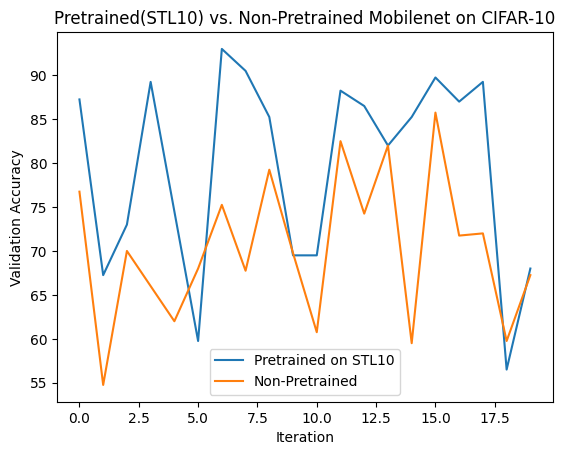

In [76]:
plt.plot(range(seed+1), accuracy13, label="Pretrained on STL10")
plt.plot(range(seed+1), accuracy5, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained(STL10) vs. Non-Pretrained Mobilenet on CIFAR-10")
plt.legend()
plt.show()


#STL10 - EFFICIENTNET


In [2]:
pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e53b6d62f458ddacd4c82cd1bceb543067fcffb5a2c94612712fe1cd070f4436
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from numpy.random import RandomState
from torchvision.models.efficientnet import efficientnet_b0
from efficientnet_pytorch import EfficientNet

# EfficientNet
def load_efficientnet(num_classes):
    model = EfficientNet.from_name("efficientnet-b0", num_classes=num_classes)
    return model




def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output)
            # print(target)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

transform_cifar_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
transform_cifar_val = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_train)
cifar_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_val)

stl10_data = datasets.STL10(root='./data', split='train', download=True, transform=transform_cifar_train)
train_size = int(0.8 * len(stl10_data))
test_size = len(stl10_data) - train_size
train_data, test_data = torch.utils.data.random_split(stl10_data, [train_size, test_size])
st10_train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
st10_val_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = load_efficientnet(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

for epoch in range(20):
  print("epoch ", epoch+1)
  train(model, st10_train_loader, criterion, optimizer, device)
  scheduler.step()

accuracy14 = test(model, st10_val_loader, device)
print(f'Accuracy on 50 CIFAR-10 samples: {accuracy14:.2f}%')

params = model.state_dict()
accuracy15 = []
for seed in range(20):
    print(f"Iteration: ", seed)
    model.load_state_dict(params)
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes =  prng.permutation(np.arange(0,10))
    indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_data, indx_train)
    val_data = Subset(cifar_data, indx_val)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size=64, 
                                              shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=64, 
                                            shuffle=False)


    for epoch in range(20):
        train(model, train_loader, criterion, optimizer, device)
    accuracy15.append(evaluate(model, device, val_loader))
    print(f'accuracy on CIFAR-10: {accuracy15[-1]:.2f}%')
   
accs16 = np.array(accuracy15)
print(f'Acc over {seed} instances: %.2f +- %.2f'%(accs16.mean(),accs16.std()))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.1797, Accuracy: 549/1000 (54.90%)

Accuracy on 50 CIFAR-10 samples: 54.90%
Iteration:  0

Test set: Average loss: 3.7145, Accuracy: 287/400 (71.75%)

accuracy on CIFAR-10: 71.75%
Iteration:  1

Test set: Average loss: 3.2165, Accuracy: 231/400 (57.75%)

accuracy on CIFAR-10: 57.75%
Iteration:  2

Test set: Average loss: 2.4381, Accuracy: 241/400 (60.25%)

accuracy on CIFAR-10: 60.25%
Iteration:  3

Test set: Average loss: 3.8629, Accuracy: 258/400 (64.50%)

accuracy on CIFAR-10: 64.50%
Iteration:  4

Test set: Average loss: 0.8494, Accuracy: 282/400 (70.50%)

accuracy on CIFAR-10: 70.50%
Iteration:  5

Test set: Average loss: 2.6777, Accuracy: 229/400 (57.25%)

accuracy on CIFAR-10: 57.25%
Iteration:  6

Test set: Average loss: 0.6908, Accuracy: 331/400 (82.75%)

accuracy on CIFAR-10: 82.75%
Iteration:  7

Test set: Average loss: 0.9935, Accuracy: 343/400 (85.75%)

accuracy on CIFAR-10: 85.75%
Iteration:  8

Test set: Average loss: 3.1994, Accuracy: 220/400 (

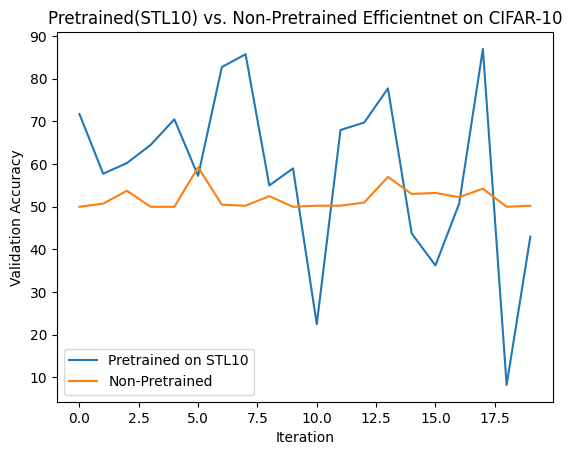

In [78]:
plt.plot(range(seed+1), accuracy15, label="Pretrained on STL10")
plt.plot(range(seed+1), accuracy7, label="Non-Pretrained")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.title("Pretrained(STL10) vs. Non-Pretrained Efficientnet on CIFAR-10")
plt.legend()
plt.show()
